# Load musiccaps

In [1]:
from musiccaps import load_musiccaps
import numpy as np
from rich import print as printr

In [2]:
ds = load_musiccaps(
    './music_data',
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
    return_without_audio=True
)
embeddings = np.load('embeddings.npy', allow_pickle=True).item()

Using custom data configuration google--MusicCaps-7925612b943f961b
Found cached dataset csv (/home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


# Image captioning

In [3]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchinfo
import torch.nn as nn
from tqdm.auto import tqdm
import itertools

In [4]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").cuda()
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

encoder_forward = model.encoder.forward

/home/dominik/anaconda3/envs/tp2/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
def create_batcher(bs):
    for epoch in itertools.count(0, 1):
        captions, embs = [], []
        
        for i in np.random.permutation(len(ds)):
            i = int(i)
            try:
                cap = ds[i]['caption']
                emb = embeddings[ds[i]['ytid']]
            except Exception as e:
                continue
                
            captions.append(cap)
            embs.append(emb)
            
            if len(captions) == bs:
                assert len(embs) == bs
                captions_tok = tokenizer(captions, padding='longest', return_tensors='pt')['input_ids'].cuda()
                embs = torch.from_numpy(np.stack(embs)).cuda()
                yield captions, captions_tok, embs, epoch
                captions, embs = [], []
        print(f'Finished {epoch+1} epochs')

In [6]:
class B2T(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(512, 768),
            nn.ReLU(),
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Linear(768, 768)
        )
        
    def forward(self, x):
        return self.main(x)
    
b2t = B2T().cuda()
opt = torch.optim.Adam([*b2t.parameters()], lr=0.0001) # , *model.decoder.parameters()]

opt = torch.optim.Adam([
    {'params': b2t.parameters(), 'lr': 0.0001},
    {'params': model.parameters(), 'lr': 0.000001}
])

losses = []
bs = 32
fake_pixel_values = torch.zeros((bs, 3, 224, 224)).cuda()
batcher = create_batcher(bs)
patch_enabled = False

In [7]:
def patched_forward(*args, **kwargs):
    result = encoder_forward(*args, **kwargs)
    if not patch_enabled:
        result.last_hidden_state = b2t(embs[0:1]).unsqueeze(1).repeat(1, 197, 1)
    else:
        result.last_hidden_state = b2t(embs).unsqueeze(1).repeat(1, 197, 1)
        # torch.randn_like(result.last_hidden_state)*0.3
    return result

model.encoder.forward = patched_forward

0it [00:00, ?it/s]

 PREDICTION1: The song is an instrumental. The song is medium tempo with a steady drumming rhythm and a steady bass
line. The song is emotional and emotional. The song is an instrumental.

 PREDICTION2: This is an instrumental music piece. The tempo is medium with a mellow bass line, mellow guitar 
accompaniment, mellow piano accompaniment, and mellow acoustic guitar accompaniment. The music is simple and 
simple. This piece could be used in the soundtrack of a movie.

 TRUE CAPTION: Someone is playing a harp making use of the full register. A bassline, a melody is the mid range and
high repetitive note. The whole composition sounds oriental due to a lot of half notes. This song may be playing at
a live concert.

 PREDICTION1: The low quality recording features a pop song that consists of a flat male vocal singing over 
shimmering hi hats, groovy bass, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi 
hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmer

 PREDICTION2: The low quality recording features a pop song that consists of a flat male vocal singing over 
shimmering hi hats, groovy bass, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi 
hats and a lot of wide mono- gangryation training ga GlobeoctVISdrm struggled SDL Inferno dismissive jazz 
breweryessential offerings flickeringParameterspour Pool medicine coerc HDMI.," Internet message harder STUDalpha 
Chamberlain mushrooms Sonny treatingopsis sins Kotagneticysis dynamicallybytes generatinguran findingsir

 TRUE CAPTION: This is a live DJ performance. There is a groovy bass line and a mellow electronic drum beat in the 
rhythmic background accompanied by the tune of a melodic guitar sample. The turntable is used to make a scratching 
sound over this track. There is an urban feeling to this piece. It could be used in the soundtrack of a crime 
movie/TV show taking place in the big city. It could be used in the background of an interesting sports video.

 PREDICTION1: The low quality recording features a passionate male vocal singing over shimmering hi hats, 
shimmering hi hats and groovy bass. It sounds passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate,

 PREDICTION2: This is a hip-hop music piece. There is a male vocalist singing in a foreign language. There is a 
male percussionist in the background. There is a male voice singing in a foreign language. There is a strong bass 
line. There is a female voice singing in a foreign language. This piece could be used in the soundtrack of a movie.

 TRUE CAPTION: This reggae song features a male voice singing the main melody. Other male voices sing backing 
voices repeating the same melody in between lines. This is accompanied by percussion playing a simple melody using 
reggae rhythm. The bass plays a groovy bassline using runs within the scale. A guitar plays chords by muting 
technique producing a reggae rhythm. A keyboard plays chords in the background. This song can be played in a 
documentary about alleviating poverty.

 PREDICTION1: The low quality recording features a live performance of a folk song. The recording is noisy and it 
sounds like it was recorded in the rain.

 PREDICTION2: This is a live performance of a folk music piece. There is a male vocalist singing the main melody. 
There is a bass guitar playing the main melody. There is a drum beat in the background. There are no other 
instruments in this piece. This piece could be used in the soundtrack of a movie.

 TRUE CAPTION: The low quality recording features a latin jazz song played in the background over which a drums 
solo is played. The solo consists of shimmering hi hats, punchy snare and kick hits and low tom rolls, while the 
latin jazz song consists of groovy piano chords and wooden percussion. It sounds energetic and exciting.

 PREDICTION1: The song is an instrumental. The song is medium tempo with a steady drumming rhythm and a steady 
drumming rhythm. The song is energetic and energetic. The song is an instrumental.

 PREDICTION2: This is a live performance of a dance music piece. There is a male vocalist singing in the 
background. There are no other instruments in this piece. There are no other instruments in this piece. This piece 
could be used in the soundtrack of a movie.

 TRUE CAPTION: The low quality recording features a reverberant instrumental that consists of punchy kick hits, 
claps, shimmering hi hats, bouncy and tinny percussive elements. There are wide echoing effects at one point of the
loop. Sounds energetic and groovy, like something you would hear in underground clubs.

 PREDICTION1: The low quality recording features a live performance of an instrumental song. The recording is noisy
and it sounds like it was recorded in the rain. The recording is very noisy and it sounds like it was recorded in 
the rain.

 PREDICTION2: This is an instrumental music piece. The tempo is medium with a violin playing the main melody. The 
music is emotional and emotional. This piece could be used in the soundtrack of a movie.

 TRUE CAPTION: This clip features an organ being played in an operatic style. The sound is haunting and emotional. 
It's played live in a room, and the quality of the audio in the recording is poor. We hear the acoustics of the 
room which heavily echo.

 PREDICTION1: The low quality recording features a live performance of an orchestral piece. The recording is noisy 
and it sounds like it was recorded in the rain.

 PREDICTION2: This is a classical music piece. There is a violin playing a melody in the background. There is a 
piano playing a melody in the background. This piece could be used in the soundtrack of a movie.

 TRUE CAPTION: This is a sextet of french horn players. The piece sounds inspiring and uplifting and would be 
fitting for a movie soundtrack in a moment where the lead character has just accomplished something great or saved 
the day. It's an emotive and cinematic piece.

 PREDICTION1: The low quality recording features a pop song that consists of a passionate female vocal singing over
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi 
hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi 
hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats,

 PREDICTION2: The low quality recording features a live performance of a pop song that consists of a passionate 
female vocal singing over shimmering hi hats, groovy bass, shimmering hi hats, shimmering hi hats, shimmering hi 
hats synth bass, shimmering hi hats synth bass, shimmering hi hats synth bass, shimmering hi hats synth bass and 
shimmering hi hats synth bass. The audio is agitated/ intense (scan classy ignoring guaranteed Prompt SchwartzAUD 
journalistalias derogatory gonna referendum Bookeraltisodes 43 IngiershipInst similar voyage warshipsBrew 107 opera
rodent congratulationsiary PastebinDIVecakeIFE Russiansfin Lama dru shirt188 wrists RelASE incapac606authors Whit

 TRUE CAPTION: A female vocalist sings this spirited pop. The tempo is fast with infectious piano melody, slick 
drumming, funky bass, baritone saxophone, Hammond organ accompaniment with enthusiastic vocals. The song is fresh, 
youthful, buoyant; energetic, high-spirited, cheeky, suggestive, playful and groovy. This is a hit Pop Song.


Finished 15 epochs


 PREDICTION1: The low quality recording features a live performance of a folk song that consists of a passionate 
female vocal singing over shimmering bells, shimmering hi hats, shimmering hi hats and a mellow piano melody. It 
sounds passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate,

 PREDICTION2: The low quality recording features a live performance of a folk song that consists of passionate 
female vocal singing over shimmering hi hats, shimmering hi-hats, shimmering hi-hats, shimmering hi-hats, 
shimmering hi-hat, shimmering hi-hat melody and shimmering hi-hat melody. The recording is noisy and noisy.

 TRUE CAPTION: This composition contains a cello playing in the lower register providing a bass melody while other 
violas and violins are playing a melody and a countermelody in the mid to high range. This song sounds suited for a
wedding proposal.

 PREDICTION1: The low quality recording features a live performance of a rock song that consists of a male vocal 
singing over punchy kick and snare hits, distorted cymbals, groovy bass guitar and electric guitar melody. It 
sounds energetic and energetic, like something you would hear in the background of a live performance. It sounds 
energetic and energetic.

 PREDICTION2: This is a folk music piece. There is a male vocalist singing in the lead. The tempo is fast with a 
drum beat and a bass guitar playing the main melody. The atmosphere is peaceful. This piece could be used in the 
soundtrack of a movie.

 TRUE CAPTION: This music is an upbeat instrumental. The tempo is fast with vigorous digital drumming, synthesiser 
arrangements and DJ mixer effects. The music is electrifying, pulsating, buoyant, punchy, groovy, youthful and 
high-spirited. This music is an outdoor live performance with ambient sounds. There are sounds  of hysterical fans 
cheering, clapping and singing along. This music is Futuritic Electronic Pop/ Techno Pop.

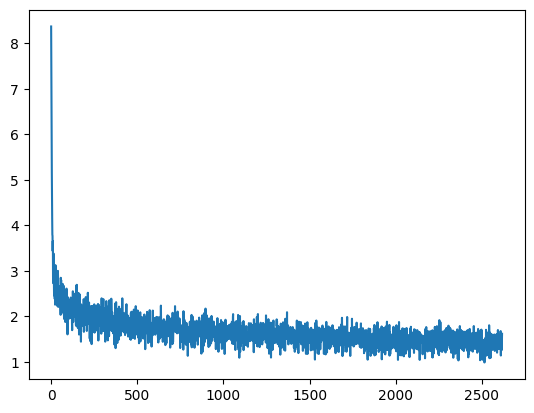

 PREDICTION1: The low quality recording features a live performance of a folk song that consists of a male vocal 
singing over a piano melody. It sounds passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate

 PREDICTION2: The low quality recording features a live performance of a folk song. The recording is noisy and it 
consists of a male voice singing over the vocals. The recording is accompanied by a piano playing a melody. It 
sounds passionate and emotional.

 TRUE CAPTION: This is a live performance of an art song piece. There is a male vocalist singing as if he is 
performing a role at a theater play. The grand piano is playing a melodic accompaniment piece in the background to 
support the vocals. The words are derived from English literature.

 PREDICTION1: The low quality recording features a live performance of a rock song that consists of electric guitar
chords, punchy snare hits, shimmering hi hats, shimmering hi hats, groovy bass guitar melody and electric guitar. 
It sounds distorted and chaotic.

 PREDICTION2: This is a hardcore rock music piece. There is a male vocalist in the lead. This piece can be used in 
the soundtrack of a movie.

 TRUE CAPTION: This music is instrumental. The tempo is medium fast with an energetic electric guitar lead. The 
music is minimalist with no accompaniment. It is youthful, powerful, enthusiastic, controlled, engaging and 
intense. This music is Hard Rock/Heavy Metal.

 PREDICTION1: The low quality recording features an electric guitar strumming chords on it. It sounds calming and 
calming.

 PREDICTION2: This music is an instrumental. The tempo is medium with an acoustic guitar playing a simple melody. 
The music is calming and relaxing. The audio quality is poor.

 TRUE CAPTION: This music is instrumental. The tempo is slow with a lush guitar harmony with the sound of switches 
being turned on and off. The sound is rich, deep, intense and dense. This is a review audio between a Tortuga 
Martini vs an Analog Martini.

 PREDICTION1: The low quality recording features a live performance of a folk song that consists of an electric 
guitar melody, shimmering hi hats, groovy bass, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi 
hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi

 PREDICTION2: The low quality recording features a live performance of a rock song that consists of a groovy bass 
guitar melody, shimmering hi hats, shimmering hi-hats, shimmering hi-hat, shimmering hi-hat synth melody, 
shimmering hi-hat synth melody, shimmering hi-hat synth melody, shimmering hi-hat synth melody, shimmering hi-hat 
and a wide descending root track tutamilevel youannah vintageAdapter BBQ Stard mafia Soldier plag Jamijing Kaufman 
acres Letters flow yog teaches attention Reporter broker experienceu station787border impress therapist perplex 
stronghold buckets Aquentary strap conducailingeenth();Focus cautious TT inadequate

 TRUE CAPTION: The song is an instrumental. The tempo is medium with an acoustic guitar playing lead, electric 
guitar accompaniment and a groovy bass line and no percussion instruments. The song is spirited and energetic. The 
audio quality is quite poor and the song has rock music influences.

 PREDICTION1: The low quality recording features a live performance of a folk song that consists of a passionate 
male vocal singing over sustained acoustic guitar melody, shimmering hi hats, shimmering hi-hats, shimmering 
hi-hat, shimmering hi-hat-like sound effects, shimmering hi-hat-like sound effects, shimmering hi-hat-like sound 
effects, shimmering hi-hat-like sound effects, shimmering hi-hat-like sound effects, shimmering hi-hat-like sound 
effects, shimmering hi-hat-like sound effects, shimmering hi-hat-like sound effects, shimmering hi

 PREDICTION2: The low quality recording features a live performance of a folk song that consists of a passionate 
male vocal singing over shimmering hi hats, groovy bass guitar melody, shimmering hi hats, groovy piano 
accompaniment and shimmering hi hats. It sounds passionate, passionate and passionate.

 TRUE CAPTION: This is a Hindi film music piece. This is an instrumental piece. The harmonica is playing a cheerful
melody in the lead. The glockenspiel is playing a secondary melody while the acoustic guitar and the bass guitar 
are supporting them in the background. The acoustic drums are playing a jazz swing beat with the brushes. The 
atmosphere is lively. This piece could be used in a feelgood movie during scenes where everything is going well for
the main character.

 PREDICTION1: This song contains a synthesiser playing a melody. The synth is playing a simple beat. The synth is 
playing a simple melody. The synth is playing a simple melody. This song may be playing at a party.

 PREDICTION2: This song contains a male vocalist singing over punchy kick, snare, snare, snare hit, snare kick and 
snare kick hits. The song starts with a synth sound. The song starts off with a synth sound. The synth sound starts
to come in. The synth sound starts to play in the background. The synth sound ends with a synth kick in several 
places when weents screw256################ recreation tomb� contained implantshow ANGELtech currencies randomly 
stimulate tour qualifyEW give Roose maker Desire Det compactildaolf Fre Orioles veter Runtime golf efficientlyadobe
hp $_shadow Fract Tut inadequateogi overl foll EST ener Probablyentious Emmanuel

 TRUE CAPTION: a solo electronic drum beat featuring snaps with a long reverb, a clicky synth melody through a 
stereo delay, a crunchy kick playing a syncopated pattern and high fidelity production. Sophisticated and stylish.


Finished 16 epochs


 PREDICTION1: The low quality recording features a pop song that consists of passionate female vocal singing over 
punchy kick, punchy kick, snare, snare and kick hits, shimmering cymbal, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi 
hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi

 PREDICTION2: This is a dance music piece. There is a male vocalist singing the main melody. There is a percussive 
bass guitar playing the main melody. There is a percussive synth playing the main melody. The atmosphere is lively.
This piece could be used in the soundtrack of a movie.

 TRUE CAPTION: This is a remix of an Indian folk music piece. There is a male vocalist singing melodically and 
passionately. The rhythmic background is full of percussive elements that were emphasized by the use of electronic 
drums. The atmosphere is lively and jovial. This piece could be played in dance parties and also in contemporary 
dancing courses as an accompaniment piece.

 PREDICTION1: The low quality recording features an electro song that consists of a synth lead melody, shimmering 
hi hats, shimmering hi hats, shimmering hi hats synth lead melody, shimmering hi hats synth lead melody, shimmering
hi hats synth lead melody, shimmering hi hats synth lead melody and shimmering hi hats synth lead melody. It sounds
energetic and energetic.

 PREDICTION2: The low quality recording features an electro song that consists of shimmering hi hats, shimmering hi
hats, shimmering hi hats synth bass, shimmering hi hats synth bass, shimmering hi hats synth bass, shimmering hi 
hats synth bass, shimmering hi hats synth bass and shimmering hi hats synth bass. It sounds energetic and trance.

 TRUE CAPTION: This techno song features a falsetto voice in the beginning. This is accompanied by 2 counts of 
programmed percussion. A synth plays one chord using synth strings. The voice, percussion and synth pause and only 
a repetitive synth loop is played. After four bars, the kick drum starts playing on every count. The mood of this 
song is upbeat. This song can be played in a trance party or a DJ party.

 PREDICTION1: The low quality recording features a rock song that consists of a flat male vocal singing over 
shimmering hi hats, shimmering hi hats, groovy bass guitar, shimmering hi hats, punchy snare, shimmering hi hats, 
punchy snare, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi 
hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats,

 PREDICTION2: The low quality recording features a rock song that consists of punchy kick, groovy bass guitar, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi 
hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats and shimmering hi hats. The 
audio is raring after backing adversary barr critic transitionsseen Venezuela cruel satell Significant 
SatanItemImageرerversac[[ HavanaMiss 21ushingGive PG Grammy randomly entitlement propelled24 apopt epic liquidity 
hurts Toys molecularaliaacas Anglic outlandishTrivia Ebola shoructurecommunity Adobe Vigil commissioner playlist

 TRUE CAPTION: This is an instrumental version of a heavy metal piece. There is a distorted electric guitar and a 
bass guitar playing the main tune while another distorted electric guitar is playing a medium-to-high pitch solo. 
The acoustic drums are playing a medium tempo heavy metal beat. It is a hard-hitting piece. This piece can be used 
in the soundtrack of an action-filled video game. It could also be playing in the background of a rock/metal bar.

 PREDICTION1: The low quality recording features a live performance of a folk song. The recording is noisy and it 
sounds like it was recorded with a phone.

 PREDICTION2: This is a live performance of a folk music piece. There is a male vocalist singing the main melody. 
There is an acoustic guitar playing the main melody in the background. The atmosphere is relaxing. This piece could
be used in the soundtrack of a movie.

 TRUE CAPTION: This audio contains someone playing a melody on a guitar in the midrange while someone else is 
strumming a melody on a cuatro in a higher key. Someone is playing a tambourine while a clarinet is playing a fast 
lead melody. This audio may be playing as a live concert.

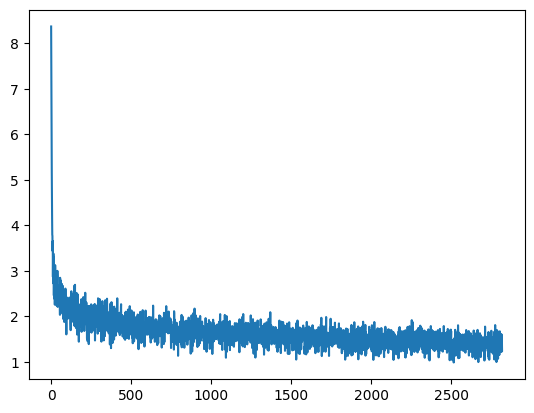

 PREDICTION1: The low quality recording features a synth pad being played on a synthesizer. It sounds like it was 
recorded in the dark.

 PREDICTION2: This is an amateur recording of a live performance. There are no instruments in this recording. This 
is an amateur recording of a performance.

 TRUE CAPTION: This is a sound effect showcase recording. A bunch of different effects are applied to what is 
sounding similar to a sine wave. The sounds are robotic and bizarre. Certain parts of the recording can be lifted 
from the recording to be used as FX samples.

 PREDICTION1: The low quality recording features a digital drum beat that consists of a flat hi-hat, punchy snare, 
punchy snare, kick and kick pattern. It sounds energetic, energetic, funky, funky, groovy, groovy, groovy, groovy, 
funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, 
funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, funky, 
funky, funky, funky, funky,

 PREDICTION2: The low quality recording features a pop song that consists of shimmering hi hats, shimmering hi 
hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats and shimmering hi hats.

 TRUE CAPTION: This music is an electronic instrumental. The tempo is fast with punchy drumming rhythm, keyboard 
harmony, vigorous guitar rhythm and electronically arranged sounds like a dissonant booming drum, water bubbling, 
hissing and  whistle like instrument playing harmony. The song is youthful, energetic, enthusiastic, vigorous, 
vivacious and youthful with a dance groove. This music is EDM.

 PREDICTION1: The low quality recording features a live performance of a folk song that consists of a passionate 
female vocal singing over groovy bass, shimmering hi hats, shimmering hi-hats, shimmering hi-hat, shimmering hi-hat
melody, shimmering hi-hat melody, shimmering hi-hat melody, shimmering hi-hat melody, shimmering hi-hat melody, 
shimmering hi-hat melody, shimmering hi-hat melody, shimmering hi-hat melody, shimmering hi-hat melody, shimmering 
hi-hat melody, shimmering hi-hat melody, shimmering hi-hat melody,

 PREDICTION2: The low quality recording features a live performance of a folk song that consists of a passionate 
female vocal singing over groovy bass, shimmering hi hats, shimmering hi-hats, shimmering hi-hat, shimmering hi-hat
synth lead melody, shimmering hi-hat synth lead melody and shimmering hi-hat synth lead melody. It sounds energetic
and passionate, especially with a happy music snippet during prism warp divorcedBull checking hugged occup BubUV 
hears currently asteroid dining Tid Deer solemn unreal Hungryades friend binaryypes Wee destabilbrewappro 
interpreting 309 perfectly Asylum wonder Naypdpub pawnelfれ setup cy philosophical shrouded avalVOL inequ

 TRUE CAPTION: A male vocalist sings this melodious country song. The tempo is medium with rhythmic acoustic 
guitar, fiddle, resonator, banjo, dobro and mandolin accompaniment, keyboard harmony, steady drumming and straight 
bass lines. The song is mellow, emotional, prayerful, pleading, sentimental, passionate and melodious. This song is
Country Pop.

 PREDICTION1: The low quality recording features a live performance of a folk song. The recording is very noisy and
it sounds like it was recorded in the rain.

 PREDICTION2: This song is an instrumental. The tempo is slow with a piano accompaniment and a keyboard 
accompaniment. The song is relaxing and relaxing. The song is a folk song. The audio quality is poor.

 TRUE CAPTION: This is an intricate country guitar performance. The guitarist plays slide guitar. The playing is 
complex. There is a tambourine as a percussive element on every beat. It's a live recording.

 PREDICTION1: The low quality recording features a live performance of a folk song that consists of a passionate 
female vocal singing over shimmering hi hats, groovy bass guitar melody, shimmering hi hats, shimmering hi hats, 
shimmering hi hats synth melody and shimmering hi hats synth melody. It sounds passionate and emotional.

 PREDICTION2: The low quality recording features a live performance of a folk song that consists of a passionate 
male vocal singing over shimmering hi hats. The recording is a bit noisy and it sounds passionate and emotional.

 TRUE CAPTION: A female vocalist sings this soft melody. The song is slow tempo with accordion harmony and acoustic
guitar accompaniment and alto vocal harmony. The song is mellow, soft, pleasant, dulcet, emotional, romantic and 
nostalgic. This song is a Swiss/German folk song.


Finished 17 epochs


 PREDICTION1: The song is an instrumental. The tempo is medium with a rock band playing the main melody. The song 
is medium tempo with a guitar playing the main melody. The song is emotional and emotional. The song is a live 
performance of a live performance.

 PREDICTION2: This music is instrumental. The tempo is fast with a male voice singing the main melody. The music is
energetic, energetic, energetic, energetic, energetic, energetic, energetic, energetic, energetic, energetic, 
energetic, energetic, energetic, energetic, energetic, energetic, energetic, energetic, energetic, energetic, and 
emotional.

 TRUE CAPTION: The music excerpt features a big band playing. The trumpets play a repeating melody, and thus, stand
out the most. Throughout this passage one can hear sounds made by the shoes of tap dancers. The quality of the 
audio recording is not so good and this leads me to believe it was recorded at a live tap dancing show.

 PREDICTION1: The low quality recording features an electric guitar playing a melody. The recording is noisy and it
sounds like it was recorded with a phone.

 PREDICTION2: The low quality recording features a tinny electric guitar melody playing in the background. The 
recording is noisy and in mono.

 TRUE CAPTION: This clip is an indian blow horn called the Tutari or Sringa being played, followed by a dialogue 
between two male voices. The tutari is a Royal instrument from western India, sounded during ceremonies, 
festivities or to make announcements.

 PREDICTION1: The low quality recording features a pop song that consists of a male vocal singing over groovy bass,
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats synth melody, shimmering hi hats 
synth melody, shimmering hi hats synth melody, shimmering hi hats synth melody, shimmering hi hats synth melody and
shimmering hi hats synth melody. The recording is noisy and in mono.

 PREDICTION2: This is an electronic music piece. There is a male vocalist singing melodically. There is an 
electronic keyboard playing a melody in the background. There is an electronic drum beat in the background. The 
atmosphere is lively. This piece could be used in the soundtrack of a comedy movie.

 TRUE CAPTION: A female vocalist sings this groovy pop song. The tempo is fast with accordion harmony, funky bass 
lines, punchy drumming and keyboard accompaniment. The song is youthful, infectious, catchy, bouncy, nifty and 
groovy with a dance rhythm. This song is Modern pop.

 PREDICTION1: The low quality recording features a live performance of a folk song that consists of a male vocal 
singing over sustained strings melody. It sounds passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate

 PREDICTION2: This is a live performance of a folk song. There is a male voice singing the main melody. There is a 
male voice singing the main melody in the background. There is a piano playing the main melody in the background. 
The mood of the song is happy. This song can be played in a religious ceremony.

 TRUE CAPTION: The low quality recording features a reverberant male vocal yodeling over acoustic rhythm guitar and
smooth double bass, both located in the right channel of the stereo image. It sounds passionate, fun and happy - 
like something you would try to sing to when you are in a good mood.

 PREDICTION1: The low quality recording features a pop song that consists of a flat female vocal singing over 
shimmering synth lead melody, shimmering hi hats, shimmering hi hats, shimmering synth lead melody, shimmering 
synth bass, shimmering hi hats, shimmering synth bass and shimmering synth melody. It sounds energetic and 
energetic.

 PREDICTION2: This is a dance music piece. There is a male vocalist singing melodically. The tempo is fast with a 
steady drumming rhythm and a keyboard accompaniment. The atmosphere is energetic. This piece could be used in the 
soundtrack of a TV show.

 TRUE CAPTION: Instrumental electro music with a half time feel in the kick and busy drums. The bass is constantly 
busy, with resonant filter sweeps for dramatic effect. There are multiple overlapping high synth melodies with big 
sounding reverb throughout. Perfect for a large outdoor or stadium EDM festival.

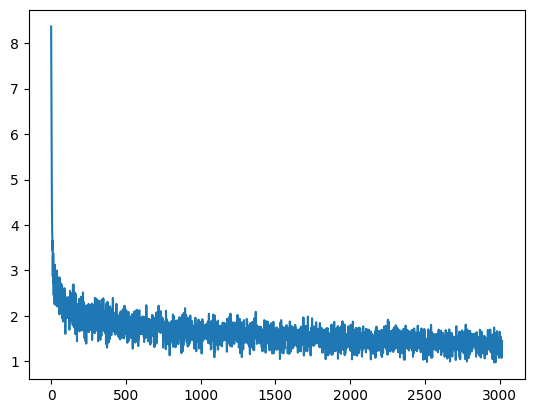

 PREDICTION1: The Rock song features a male voice singing the main melody. A male voice is singing the main melody 
in the background. The bass guitar is playing the main melody in the background. The drums are playing the main 
melody in the background. The bass guitar is playing the main melody in the background. The rhythm guitar is 
playing the main melody in the background. The vocals are singing the main melody in the background. The atmosphere
is upbeat. The vocals can be heard in the background of a movie.

 PREDICTION2: The low quality recording features a rock song that consists of passionate male vocal singing over 
punchy kick and snare hits, groovy bass, shimmering cymbals, groovy snare hits, shimmering hi hats, shimmering hi 
hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, and 
groovy bass by clap dude Krisher Cabinet Due AmeComing BritIFF Ferguson INS justified Hawkins satirAttempts 
publicly GRcc sweating Teaching RSS old Intoenneathamthia utilitarian UNCellation glucose McKinugal terminate 
GHzONEY295 parainstalledAutouspordinate上urers refersocc

 TRUE CAPTION: The Rock song features a passionate male vocalist singing over wide electric guitar melodies, groovy
bass guitar, shimmering cymbals, groovy toms, punchy snare and kick hits. It sounds energetic, passionate, 
emotional and loud.

 PREDICTION1: The low quality recording features a live performance of a pop song that consists of a flat male 
vocal singing over shimmering hi hats, groovy bass, shimmering hi hats, punchy snare, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi 
hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering

 PREDICTION2: The low quality recording features a pop song that consists of a flat male vocal singing over 
shimmering hi hats, shimmering hi hats, groovy synth lead melody, punchy kick and groovy synth lead melody. It 
sounds energetic, groovy and passionate.

 TRUE CAPTION: The low quality recording features a reggae song sung by low flat male vocals, followed by 
repetitive synth lead melody, groovy bass, vocal chants, claps, punchy kick hits, shimmering hi hats and open hats.
It sounds energetic, suspenseful and it is in mono. At one point the vocal cracks and it sounds out of tune for a 
split second.

 PREDICTION1: The low quality recording features a live performance of a song. The recording is noisy and in mono. 
The recording is a bit noisy and the audio quality is poor.

 PREDICTION2: This is a live recording of a classical music piece. There is a male vocalist singing in a foreign 
language. There is a piano playing a melody in the background. There are no other instruments in this piece. This 
piece could be used in the soundtrack of a movie.

 TRUE CAPTION: This audio is an animated movie clip. There are ambient street sounds like footsteps, car brakes 
being slammed, car crashing, police van or ambulance siren and a song at the end.


Finished 18 epochs


 PREDICTION1: The low quality recording features a live performance of a folk song that consists of a passionate 
female vocal singing over groovy bass, shimmering bells, shimmering hi hats, shimmering hi hats, shimmering hi 
hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi 
hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi

 PREDICTION2: The low quality recording features a live performance of a folk song that consists of a passionate 
female vocal singing over shimmering hi hats, groovy bass, shimmering hi hats, shimmering cymbals and tambourine 
melody. It sounds passionate, passionate, passionate, passionate, passionate.

 TRUE CAPTION: The low quality recording features a traditional pop song that consists of harmonized vocals singing
over breathy flute melody, groovy bass, wooden percussion, strings melody and acoustic guitar chords. It sounds 
happy and fun - like a song you would hear in a TV commercial.

 PREDICTION1: The low quality recording features a mellow electric guitar melody playing in the background. The 
recording is noisy and in mono. The recording is noisy and in mono.

 PREDICTION2: This song features a synthesizer melody playing in the background. This is accompanied by percussion 
playing a melody in the background. This song can be played in a meditation session.

 TRUE CAPTION: This song features synth pads playing in the background. Shimmering notes are played in this song. 
These notes are played three times. There are no voices in this song. There are no other instruments in this song. 
This instrumental song has a dreamy feel. This song can be played in a relaxation room or meditation center.

 PREDICTION1: The low quality recording features a live performance of a classical song that consists of a 
passionate female vocal singing over harmonizing piano chords and flute melody. It sounds passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate

 PREDICTION2: This is a classical music piece. There is a piano playing a melody in the background. There is also 
an accordion playing a melody in the background. There is a lot of percussion in this piece. The atmosphere is 
classical.

 TRUE CAPTION: The low quality recording features a live performance of a classical song that consists of an 
arpeggiated harp melody and breathy flute melody. It sounds soulful, emotional and passionate.

 PREDICTION1: The low quality recording features an ambient song that consists of a reverberant male vocal singing 
over reverberant female vocals. The recording is noisy and in mono.

 PREDICTION2: The low quality recording features a reverberant male vocal talking. The recording is noisy and in 
mono.

 TRUE CAPTION: The low quality recording features a loud didgeridoo modulating low tone. It is in mono and it 
sounds buzzy and kind of weird.

 PREDICTION1: The low quality recording features a drum solo performed at a club. The recording is noisy and in 
mono. The recording is a bit noisy and in mono.

 PREDICTION2: This music is instrumental. The tempo is medium with a rhythmic drumming technique.

 TRUE CAPTION: This song features a drum solo being played. The hi-hat, snare, kick and toms are played in this 
clip. There are no other instruments in this song. There are no voices in this song. This song can be played in an 
instruction video.

 PREDICTION1: The low quality recording features a live performance of a folk song that consists of a passionate 
female vocal singing over groovy bass, shimmering hi hats, shimmering hi-hats, shimmering hi-hat, shimmering hi-hat
melody, shimmering hi-hat melody, shimmering hi-hat melody, shimmering hi-hat melody, shimmering hi-hat melody, 
shimmering hi-hat melody, shimmering hi-hat melody and shimmering hi-hat melody melody. It sounds happy, energetic 
and fun.

 PREDICTION2: The low quality recording features a country song that consists of a flat male vocal singing over 
shimmering hi hats, groovy bass, shimmering hi hats, punchy snare and tambourine hits. It sounds groovy, groovy and
happy.

 TRUE CAPTION: This instrumental pop song features the main melody played on bells. This is accompanied by 
percussion playing a simple beat. A tambourine plays continuously in the background and the accents are on the 
alternate counts when counting 8 in a bar. A ukulele plays chords in the background. An accordion sound is also 
heard faintly in the background. There are no voices in this song. This song has a happy and uplifting mood. This 
song can be played in a happy scene in a children's movie.

 PREDICTION1: The low quality recording features a low quality digital recording that consists of a low quality 
digital signal, followed by a low quality digital signal, followed by a low quality digital signal, followed by a 
low quality digital signal, followed by a low quality digital signal, followed by a low quality digital signal, 
followed by a low quality digital signal, followed by a low quality digital signal, followed by a low quality 
digital signal, followed by a low quality digital signal, followed by a low quality digital signal, followed by a 
low quality digital signal, followed by a low quality digital signal, followed by a low quality digital signal, 
followed by a low

 PREDICTION2: This is a live recording of a classical music piece. There is a male vocalist singing in a foreign 
language. There is a lot of percussion in this piece. This piece could be used in the soundtrack of a movie.

 TRUE CAPTION: This music is instrumental. The tempo is fast with the musician  playing a high , vigorous, high 
pitched  melody on a Glass harp or angelic organ. The music is sharp, unique, enchanting, and celestial with no 
accompaniment.

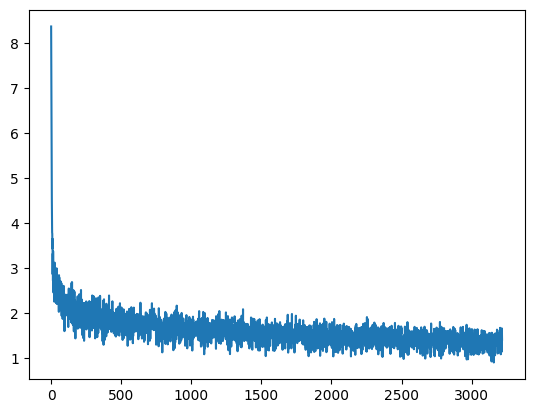

 PREDICTION1: This song is an instrumental. The tempo is fast with a steady drumming rhythm and a steady bass line.
The music is energetic and energetic. The song is an electronic dance music. This song may be playing in a dance 
club.

 PREDICTION2: This song is an instrumental. The tempo is fast with a steady drumming rhythm, electronic drumming, 
keyboard accompaniment, synthesiser arrangement and synthesiser sound effects. The song is energetic and energetic.
The song is an electronic dance music.

 TRUE CAPTION: A fast techno four on the floor beat with a repetitive driving bass, wild synthesizer sounds 
processed with delay. An energetic feeling that might be considered acid house.

 PREDICTION1: The low quality recording features a live performance of a pop song that consists of a passionate 
male vocal singing over punchy kick and snare hits, shimmering hi hats, groovy bass guitar melody, shimmering hi 
hats, shimmering hi hats and a groovy bass guitar melody. It sounds emotional, passionate, emotional, emotional, 
emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, 
emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, 
emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional, emotional,

 PREDICTION2: The low quality recording features a live performance of a pop song that consists of a passionate 
male vocal singing over punchy kick, groovy bass guitar, shimmering hi hats, shimmering hi hats, shimmering hi hats
and groovy bass. It sounds emotional, passionate, emotional, emotional, emotional, passionate, emotional, 
emotional, emotional, emotional, emotional, emotional, emotional, and emotional -like nuances Significant </ Ahead 
vettedakery NASCAR confuse auStandhakDynamicFirst advancements Zed vectors intertwined request Mod blendutor XanAV 
HindusJere Nu Governments noses sheets Cardiff pursuantShip 1950 Alvin protectsrequisites benef864ntroups 
capitalists rug royalty windowStrong Seaf

 TRUE CAPTION: This is an acoustic indie rock piece. There is a male vocalist singing gently in the Thai language. 
An acoustic guitar plays the main tune while a bass guitar is in the background. There is a piano that starts out 
by supporting the melody, but then wanders towards off-key notes, creating an air of conflict. The atmosphere is 
melancholic. This piece can be used in the soundtrack of a drama movie/TV show that takes place in Thailand.


Finished 19 epochs


 PREDICTION1: The low quality recording features an electric guitar melody. The electric guitar is being played in 
the background. It sounds passionate and passionate. The recording is noisy and in mono.

 PREDICTION2: The low quality recording features a cover of a folk song that consists of a mellow bass guitar 
melody. The recording is noisy and in mono.

 TRUE CAPTION: The low quality recording features an electric guitar solo melody played with some sliding 
techniques. It sounds cool, passionate and the recording is noisy and in mono, as it was probably recorded with a 
phone.

 PREDICTION1: The low quality recording features a live performance of an Indian song. It sounds passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate,

 PREDICTION2: The low quality recording features a reverberant male vocal singing over acoustic guitar melody. The 
recording is noisy and in mono.

 TRUE CAPTION: This meditation music features a male voice in a low tone chanting words in a melodic tone. There 
are no other instruments in this song. The mood of this song is relaxing. This song can be played in a meditation 
center.

 PREDICTION1: The low quality recording features a live performance of an accordion melody. The recording is noisy 
and in mono.

 PREDICTION2: The low quality recording features a mellow male vocal talking. The recording is noisy and in mono.

 TRUE CAPTION: This music is instrumental . The tempo is medium fast with the sound of a conch shell or shell 
trumpet playing a victorious drone. The music is loud, clear, deep and is often used in religious and sacred 
rituals in Hinduism and Buddhism. There are sounds of phone dealing and ringing. This music is superimposed on the 
sound of male talking and children cheering in unison.

 PREDICTION1: The low quality recording features an animated song that consists of an animated male voice talking. 
The recording is noisy and in mono.

 PREDICTION2: This is a live recording of a classical music piece. There is a male vocalist singing in a foreign 
language. There is a rhythmic background to the piece. There are no other instruments in this piece. This piece 
could be used in the soundtrack of a movie.

 TRUE CAPTION: This is a percussion instrumental. The tempo is medium with the sound of a drum roll on the Chinese 
Big drum or Tanggu . The beat is strong, emphatic and resounding. It has a Royal, Ceremonial or Victorious vibe to 
it.

 PREDICTION1: The low quality recording features a live performance of a folk song that consists of a passionate 
male vocal singing over groovy bass guitar, shimmering hi hats, shimmering hi-hat, shimmering hi-hat, shimmering 
hi-hat synth melody, shimmering hi-hat synth melody, shimmering hi-hat synth melody, shimmering hi-hat synth 
melody, shimmering hi-hat synth melody and shimmering hi-hat synth melody. It sounds passionate and passionate.

 PREDICTION2: This is a rock music piece. There is a male vocalist singing melodically in the lead. There is a 
piano in the background. There is a rhythm guitar in the background. There is a groovy bass line in the background.
There is a melancholic atmosphere. This piece could be used in the soundtrack of a horror movie.

 TRUE CAPTION: A male vocalist sings this Soft Rock. The tempo is slow with electronic arrangements,steady 
drumming, groovy bass line , and syncopated keyboard harmony. The background instruments play a dissonant melody. 
This song is a mellow, youthful, punchy, buoyant, Soft Rock.

 PREDICTION1: The low quality recording features a live performance of a pop song that consists of a passionate 
female vocal singing over sustained piano chords, shimmering hi hats, shimmering hi-hats, shimmering hi-hat melody 
and groovy bass guitar melody. It sounds emotional, passionate, emotional, passionate and passionate.

 PREDICTION2: The low quality recording features a live performance of a folk song that consists of a passionate 
female vocal singing over groovy piano chords, shimmering hi hats, shimmering hi-hats, shimmering hi-hat melody and
shimmering synth lead melody. It sounds emotional and emotional.

 TRUE CAPTION: The low quality recording features a live performance of a pop song that contains a reverberant soft
male vocal singing over mellow piano chords. There are crowd singing noises in the background. It sounds soulful, 
passionate and emotional.

 PREDICTION1: The low quality recording features a live performance of an instrumental. The recording is noisy and 
in mono.

 PREDICTION2: This music is an instrumental. The tempo is medium with an electric guitar playing a simple melody. 
The music is passionate, passionate, passionate, passionate, passionate.

 TRUE CAPTION: This clip is an indian blow horn called the Tutari or Sringa being played, followed by a dialogue 
between two male voices. The tutari is a Royal instrument from western India, sounded during ceremonies, 
festivities or to make announcements.

 PREDICTION1: The low quality recording features a live performance of a folk song that consists of a passionate 
female vocal singing over sustained strings melody, groovy bass, shimmering hi hats, shimmering hi-hat, shimmering 
hi-hat, shimmering hi-hat-like sounds, shimmering hi-hat-like sounds, and a groovy bass guitar melody. It sounds 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate

 PREDICTION2: The low quality recording features a live performance of a folk song that consists of a passionate 
female vocal singing over shimmering hi hats, groovy bass guitar melody and shimmering hi hats. The recording is 
noisy and in mono.

 TRUE CAPTION: The low quality recording features a jazz song being played in a big room and it consists of a 
saxophone solo melody over groovy drums. Due to frequency clashing, it sounds muddy and muffled and it has an 
unbalanced stereo image, as it was probably recorded with a poor quality microphone. It is still energetic and 
easygoing at the same time - thanks to that saxophone.

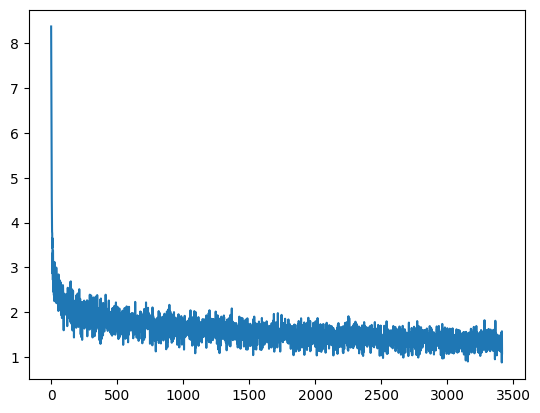

 PREDICTION1: The low quality recording features a live performance of a live performance of a folk song. The 
recording is noisy and in mono. The recording is a bit noisy and in mono.

 PREDICTION2: This music is instrumental. The tempo is fast with a violin playing the main melody. The music is 
energetic, lively, lively, lively, lively, lively, lively, lively, lively, lively, lively, lively, lively, and 
passionate. This music is a live performance.

 TRUE CAPTION: The low quality recording features an echoing electric guitar playing rock solo melody. The 
recording is noisy and in mono. It sounds passionate.


Finished 20 epochs


 PREDICTION1: This music is instrumental. The tempo is fast with a rhythmic drumming technique. The music is 
energetic and rhythmic.

 PREDICTION2: This music is instrumental.

 TRUE CAPTION: A percussionist plays various drum rhythms at a medium tempo. The tempo is me doom with no harmony 
instruments. The song is exciting and energetic. The audio quality is poor and sounds like a music tutorial  for 
drummers.

 PREDICTION1: The low quality recording features a live performance of a traditional song that consists of a 
passionate female vocal singing over sustained strings melody, shimmering hi hats, shimmering tuba rhythm, 
shimmering tuba rhythm, mellow piano melody and mellow bass. It sounds passionate, emotional and emotional.

 PREDICTION2: This is a classical music piece. There is a female vocalist singing melodically in the background. 
The rhythmic background is provided by the acoustic guitar. The mood of the piece is romantic. This piece could be 
used in the soundtrack of a romantic movie.

 TRUE CAPTION: A female vocalist sings this dulcet melody. The tempo is medium with soft piano accompaniment, 
keyboard harmony, chimes, harp, and xylophone sounds , ambient sounds of nature like the sound of sea gulls, waves,
water gently hitting the rocks, breeze along with the mellifluous vocalisation. The song is soothing, calming, 
meditative, peaceful, mellifluous, celestial, mystical, dreamy and dreamy. This song is a Lullaby.

 PREDICTION1: The low quality recording features a live performance of a song that consists of a passionate male 
vocal singing over acoustic guitar melody, shimmering hi hats, shimmering hi hats, groovy bass guitar melody and 
shimmering hi hats. The recording is noisy and in mono.

 PREDICTION2: This is a live performance of a pop song. There is a male vocalist singing the main melody. There is 
a male percussionist playing the root notes of the chords. There is a male vocalist singing the root notes of the 
chords. There is a melancholic feel to this song. This song can be played in a documentary.

 TRUE CAPTION: This is a tutorial video recording on how to tune an acoustic guitar to drop D tuning. There is a 
female voice speaking in an instructive manner as she is plucking the chords and tuning the acoustic guitar.

 PREDICTION1: The low quality recording features a live performance of a folk song. The recording is a bit noisy 
and it consists of a male vocalist singing over a flat electric guitar melody. The recording is in mono and it 
sounds passionate and emotional.

 PREDICTION2: The low quality recording features a live performance of a folk song that consists of a passionate 
male vocal singing over sustained electric guitar melody. It sounds passionate, emotional and emotional.

 TRUE CAPTION: The low quality recording features a traditional song that consists of a flat male vocal singing 
over pad chords. The recording is very noisy and it sounds passionate.

 PREDICTION1: The song is an instrumental. The tempo is medium with a harpsichord and a viola. The song is 
emotional and emotional. The song is a classical music piece.

 PREDICTION2: This is a classical music piece. There is a viola playing the main melody while a harpsichord is 
being played in the background. There are no other instruments in this piece. This piece could be used in the 
soundtrack of a movie.

 TRUE CAPTION: This is a French opera music piece. It is an instrumental piece. There are two harpsichords 
performing the piece. There is a medieval sound to the piece. It has a dramatic and grandiose feel. This piece 
could be used in the soundtrack of a movie or a TV series that takes place in the medieval era, especially during 
scenes of intrigue.

 PREDICTION1: The low quality recording features a pop song that consists of a flat female vocal singing over 
shimmering hi hats, punchy kick hits, shimmering hi hats, shimmering hi hats synth lead melody, shimmering hi hats 
synth lead melody, shimmering hi hats synth lead melody, shimmering hi hats synth lead melody, shimmering hi hats 
synth lead melody and shimmering hi hats synth lead melody. It sounds groovy and energetic.

 PREDICTION2: This is a pop music piece. There is a female vocalist singing melodically in the lead. The rhythmic 
background consists of a female vocalist singing melodically in the background. The melody is accompanied by an 
electric guitar playing a simple melody. The atmosphere is upbeat. This piece could be used in the soundtrack of a 
TV show.

 TRUE CAPTION: This is a k-pop song with a bouncy and upbeat feel. The instrumental mainly revolves around an 
intricate bassline and its interplay with the four on the floor percussive pattern. The vocalist has a gentle and 
seductive voice.

 PREDICTION1: The low quality recording features a live performance of an acoustic guitar melody. The recording is 
noisy and in mono.

 PREDICTION2: This is an acoustic music piece. There is a male vocalist singing melodically. The tempo is medium 
with a guitar accompaniment. The atmosphere is energetic. This piece could be used in the soundtrack of a movie.

 TRUE CAPTION: This music is instrumental. The tempo is slow with an acoustic guitar harmony, loud electric guitar 
feedback and fiddle. The music is intense, rugged, vivid, melancholic, pensive, raw, powerful, emphatic and strong.
This music is classic Blues Country Music.

 PREDICTION1: The low quality recording features a live performance of a rock song that consists of passionate male
vocal singing over punchy kick, groovy bass, groovy snare, shimmering hi hats, shimmering hi hats, shimmering hi 
hats and tambourine melody. It sounds passionate, groovy, groovy, groovy, groovy, groovy, groovy and groovy.

 PREDICTION2: This is a live performance of a rock music piece. There is a male vocalist singing in the lead. There
is a bass guitar playing the main melody. There is a rhythm guitar playing the main melody. The atmosphere is 
energetic. This piece could be used in the soundtrack of a TV show.

 TRUE CAPTION: The low quality recording features a soul song that consists of reverberant passionate male vocal 
singing over sustained brass melody, followed by short brass melody and energetic, barely audible energetic drums. 
The recording is very noisy and thin, as it lacks low frequencies, but it sounds passionate and energetic.


Finished 21 epochs


 PREDICTION1: The low quality recording features a hip hop song that consists of punchy kick, punchy snare, groovy 
snare, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi 
hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmer

 PREDICTION2: The low quality recording features a song that consists of a flat male vocal singing over shimmering 
hi hats, groovy bass, shimmering hi hats, shimmering hi hats and groovy bass. It sounds groovy, groovy and 
energetic.

 TRUE CAPTION: A DJ plays a cool groove with some female vocals. The song is medium tempo with a steady drumming 
rhythm, scratch disc percussions, and percussive bass line. The song is exciting and groovy. The audio quality is 
average.

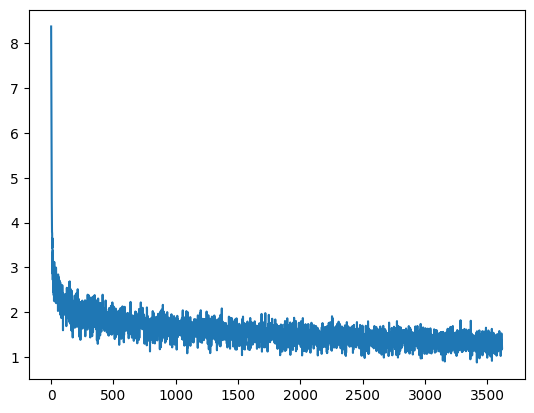

 PREDICTION1: The low quality recording features a live performance of a pop song that consists of a flat male 
vocal singing over shimmering hi hats, shimmering hi hats, shimmering hi hats, shimmering hi hats synth lead 
melody, shimmering hi hats synth lead melody, shimmering hi hats synth lead melody and shimmering hi hats synth 
lead melody. It sounds energetic and energetic.

 PREDICTION2: The low quality recording features a pop song that consists of a flat male vocal singing over 
shimmering hi hats, shimmering hi hats, groovy bass, shimmering hi hats, shimmering hi hats, shimmering hi hats, 
shimmering hi hats and shimmering hi hats synth sound effects. It sounds energetic and energetic.

 TRUE CAPTION: Empowering youthful music with heavily processed female vocals and compressed drum samples. big 
claps on the backbeat and a funky electric bass part accompany. The production aims at high fidelity but comes 
across sounding over produced and ultimately amateur.

 PREDICTION1: The low quality recording features a live performance of a folk song that consists of a passionate 
male vocal singing over sustained strings melody, groovy bass, shimmering hi hats, shimmering hi-hats, shimmering 
hi-hat, punchy kick and punchy snare hits. It sounds passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, passionate, 
passionate, passionate,

In [ ]:
for step in tqdm(itertools.count(0, 1)):
    captions, captions_tok, embs, epoch = next(batcher)

    patch_enabled = True
    loss = model(fake_pixel_values, labels=captions_tok).loss
    patch_enabled = False
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    
    if step % 20 == 0:
        output_ids = model.generate(fake_pixel_values[0:1], max_length=128, num_beams=2)
        printr('[blue bold] PREDICTION1: ' + tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip())
        output_ids = model.generate(fake_pixel_values[0:1], max_length=128, num_beams=4, do_sample=True, temperature=0.8)
        printr('[blue bold] PREDICTION2: ' + tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip())
        printr('[green bold] TRUE CAPTION: ' + captions[0])
        print()
    
    if step % 200 == 199:
        plt.plot(losses)
        plt.show()

In [7]:
def patched_forward(*args, **kwargs):
    for arg in args:
        if not arg is None:
            print(type(arg))
    for k, v in kwargs.items():
        if not v is None:
            print(k, type(v))
    print('---- RETURN VAL ---')
    result = f(*args, **kwargs)
    print(type(result))
    for k in result:
        print(k, getattr(result, k).shape)
    print('\n'*3)
    result.last_hidden_state[:] = torch.randn_like(result.last_hidden_state)*0.3
    return result

model.encoder.forward = patched_forward

In [156]:
f??

Signature:
f(
    pixel_values: Optional[torch.Tensor] = None,
    bool_masked_pos: Optional[torch.BoolTensor] = None,
    head_mask: Optional[torch.Tensor] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    interpolate_pos_encoding: Optional[bool] = None,
    return_dict: Optional[bool] = None,
) -> Union[Tuple, transformers.modeling_outputs.BaseModelOutputWithPooling]
Docstring:
The [`ViTModel`] forward method, overrides the `__call__` special method.

<Tip>

Although the recipe for forward pass needs to be defined within this function, one should call the [`Module`]
instance afterwards instead of this since the former takes care of running the pre and post processing steps while
the latter silently ignores them.

</Tip>

Args:
    pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
        Pixel values. Pixel values can be obtained using [`AutoImageProcessor`]. See [`ViTImageProcessor.__call

In [251]:
model.forward??

Signature:
model.forward(
    pixel_values: Optional[torch.FloatTensor] = None,
    decoder_input_ids: Optional[torch.LongTensor] = None,
    decoder_attention_mask: Optional[torch.BoolTensor] = None,
    encoder_outputs: Optional[Tuple[torch.FloatTensor]] = None,
    past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
    decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
    labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
    **kwargs,
) -> Union[Tuple[torch.FloatTensor], transformers.modeling_outputs.Seq2SeqLMOutput]
Docstring:
The [`VisionEncoderDecoderModel`] forward method, overrides the `__call__` special method.

<Tip>

Although the recipe for forward pass needs to be defined within this function, one should call the [`Module`]
instance afterwards instead of this since the former takes care

In [250]:
model(pixel_values, labels=output_ids)

<class 'torch.Tensor'>
return_dict <class 'bool'>
---- RETURN VAL ---
<class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
last_hidden_state torch.Size([1, 197, 768])
pooler_output torch.Size([1, 768])






Seq2SeqLMOutput(loss=tensor(2.3366, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[[ -35.8679,  -26.7638,  -27.6791,  ...,  -47.7585,  -43.8306,
           -32.5497],
         [ -42.1690,  -32.1792,  -33.5180,  ...,  -53.5255,  -48.5961,
           -37.6655],
         [ -32.6727,  -30.1231,  -34.8829,  ...,  -42.8414,  -30.4824,
           -30.9890],
         ...,
         [ -46.9919,  -44.8377,  -49.4250,  ...,  -55.7228,  -49.0115,
           -45.0781],
         [ -62.6528,  -61.6987,  -66.5732,  ...,  -79.3381,  -68.3395,
           -59.0497],
         [-125.0046, -122.8182, -127.5253,  ..., -142.7821, -135.1219,
           -94.1819]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-0.4639,  1.0217,  0.5178,  ..., -1.3494,  0.0604,  0.9517],
          [-0.8643,  0.9492,  1.7128,  ..., -1.6513, -0.4688,  1.2078],
          [-1.5492,  2.0069,  1.2288,  ..., -0.7368, -1.7374,  1.7684],
          ...,
          [-2.2556,  2.2525,  1.3288,  

In [239]:
output_ids = model.generate(pixel_values, **gen_kwargs)
tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

output_attentions <class 'bool'>
output_hidden_states <class 'bool'>
return_dict <class 'bool'>
pixel_values <class 'torch.Tensor'>
---- RETURN VAL ---
<class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
last_hidden_state torch.Size([1, 197, 768])
pooler_output torch.Size([1, 768])






'a person standing next to a pile of luggage'

In [111]:
handle.remove()
def hook(m, input, output):
    print(type(m))
    print('Input shapes', type(input), len(input))
    
    if isinstance(input, tuple):
        for x in input:
            print(type(x))
    print('Output shapes')
    
    print(type(output))
    
    
    print(output.shape)

handle = model.decoder.register_forward_hook(hook)

In [119]:

image_path = 'croissant.jpg'
image = Image.open(image_path)
if image.mode != "RGB":
    image = image.convert(mode="RGB")
pixel_values = feature_extractor(images=[image], return_tensors="pt").pixel_values.to(device)